In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


import numpy as np
from slam.utils.visualize import plotMatrix

import matplotlib.pyplot as plt
# %matplotlib widget
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import mutual_information, Statevector, partial_trace, concurrence, entanglement_of_formation
from slam.basisv2 import CircuitTemplateV2
from slam.utils.gates.custom_gates import CirculatorSNAILGate
from slam.cost_function import BasicCostInverse, BasicCost, BasicReducedCost
from slam.optimizer import TemplateOptimizer
import h5py

Using a wrapper lambda to fix parameter values in the basis gate for all search time. (Alternative is to fix only at beginning by overriding the beginning parameter guess - say if want to start near some known value but on new attempt let other variable that were previously fixed have some wiggle room)

In [2]:
# from slam.basisv2 import CircuitTemplateV2
# from slam.utils.gates.custom_gates import CirculatorSNAILGate
# bind_lambda = lambda g_ab, t: CirculatorSNAILGate(0, 0, 0, np.pi/2, 0, 0, t)
# basis = CircuitTemplateV2(n_qubits=3, base_gates = [bind_lambda], edge_params=[[(0,1,2)]])
# basis.build(2)
# basis.spanning_range = range(2,3)
# basis.circuit.draw(output='mpl')

In [3]:
# basis.add_bound("Q1", max=1, min=0)
# basis.add_bound("Q3", max=1, min=0)

This template is same as from continuous_basis now, we have 2 iswap gates that are free to adjust their times. However, we have a 3rd qubit ancilla. That probably is not very helpful - we should remove it and just rewrite the gate class to be more adaptive. I think this test is at least a good way to quantify how much harder the increased hilbert space is for training - keeping the 3rd qubit just as ancilla.

In [4]:
# from slam.cost_function import BasicCostInverse, BasicCost
# objective1 = BasicCost()
# objective2 = BasicCostInverse()
# from slam.optimizer import TemplateOptimizer
# optimizer = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True)

In [5]:
# from slam.sampler import HaarSample
# sampler = HaarSample(seed=0,n_samples=1)
# s = [s for s in sampler][0]
# s = np.kron(s, np.eye(2))
# ret = optimizer.approximate_target_U(s)

In [6]:
# basis.build(ret.cycles)
# circuit =basis.assign_Xk(ret.Xk)
# print("Decomposition Fidelity", objective1.unitary_fidelity(basis.eval(ret.Xk), s))
# print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
# print("Total Fidelity", 1-ret.loss_result)
# circuit.draw(output='mpl')

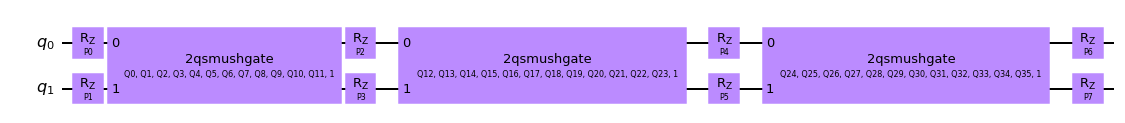

In [11]:
from slam.basisv2 import CircuitTemplateV2
from slam.utils.gates.custom_gates import RiSwapGate
from slam.utils.gates.custom_gates import ConversionGainSmushGate, ConversionGainGate


# if using riswap
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])
# basis_str = "riswap"

# if using the 2Q gate
duration_1q = 0.25
t= 1.0

# varg_offset = 2
# pp2 =lambda *vargs: ConversionGainSmushGate(0,0 , vargs[0], vargs[1], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
# basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp2], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
# basis_str = "CG2Q"

varg_offset = 4
pp3 =lambda *vargs: ConversionGainSmushGate(vargs[0], vargs[1], vargs[2], vargs[3], vargs[varg_offset:varg_offset+round(t/duration_1q)], vargs[varg_offset+round(t/duration_1q):], t_el=t)
basis = CircuitTemplateV2(n_qubits=2, base_gates = [pp3], edge_params=[[(0,1)]], vz_only=True, param_vec_expand=[varg_offset,round(t/duration_1q),round(t/duration_1q)])
basis_str = "CG2Q+P"

# need to build first before can assign bounds
basis.build(3)
basis.spanning_range = range(1,2)

#for all smush gates make bounds
bounds_1q = 4*np.pi
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, bounds_1q, -bounds_1q)

# manually set the gc, gg bounds
for el in basis.circuit.parameters:
    s_el = str(el)
    if s_el in ["Q0", "Q1", "Q22", "Q23", "Q44", "Q45"]:
        basis.add_bound(s_el, 0.5*np.pi, 0)


# print out for confirmation 
basis.circuit.draw(output='mpl')

In [14]:
# from slam.sampler import HaarSample
# sampler = HaarSample(seed=0,n_samples=1)
# s = [s for s in sampler][0]

from slam.sampler import HaarSample, GateSample
#sampler = HaarSample(seed=0,n_samples=1) #don't care
from qiskit.circuit.library import CXGate, CZGate, SwapGate, iSwapGate
#sampler = GateSample(gate = CZGate())
#sampler = GateSample(gate = CZGate())
# sampler = GateSample(gate = SwapGate())
sampler = GateSample(gate = iSwapGate().power(1/2))
s = [s for s in sampler][0]

In [9]:
# Here we want to save the best cost as a function of the success threshold
# success_thresholds = [0.99, 0.999, 0.9999, 0.99999, 0.999999]
success_thresholds = [0.999999]
fidelities = [None]*len(success_thresholds)
for k, success_threshold in enumerate(success_thresholds):
    objective1 = BasicCost()
    # keep trying until success_threshold converges:
    i=0
    LB = 1.25
    UB = 1.5
    current_cost = (UB - LB)/2

    # keep trying until success_threshold converges:
    while i == 0 or np.abs(current_cost - previous_cost) > 0.01:
        if not current_cost is None:
            basis.set_constraint(param_max_cost=current_cost)
            #pass
        #rebuild optimizer to refresh the updated f_basis obj
        #NOTE setting the success threshold low since SWAP is very hard to find exactly
        optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True, success_threshold = 1- success_threshold, training_restarts=25)

        _ret3 = optimizer3.approximate_target_U(s)
        current_cost = basis.circuit_cost(_ret3.Xk)
        print(f"Iteration:{i}, Decomposition Result:{_ret3.loss_result}, Cost:{current_cost},")

        #search using 2 steps forward, 1 step back approach BAD
        # I want to do a binary search between 0 and 1.5 
        # if success, then set next cost to be current - LB / 2
        # if fail, then set next cost to be current + (UB - current) / 2
        
        if _ret3.success_label:
            ret3 = _ret3
            fidelities[k] = ret3

            #success means can tighten the constraint
            previous_cost = current_cost
            current_cost = (current_cost - LB)/2
            print("Success, new cost:", current_cost)

        else:
            #fail means loosen the constraint
            previous_cost = current_cost
            current_cost = current_cost + (UB - current_cost)/2
            print("Fail, new cost:", current_cost)
    
        i+=1

    # save fidelities to h5 file
    with h5py.File(f'swap_fidelities_{basis_str}.h5', 'a') as hf:
        #if dataset exists, delete it
        if f"success_{success_threshold}" in hf:
            del hf[f"success_{success_threshold}"]
        hf.create_dataset(f"success_{success_threshold}", data=fidelities[k])

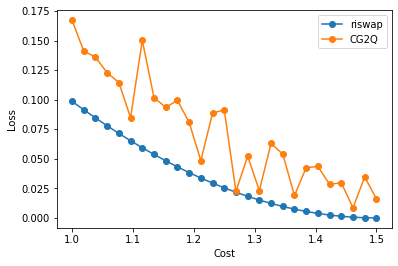

In [10]:
# # load from file
# basis_str_list = ["riswap", "CG2Q"]
# for basis_str in basis_str_list:
#     cost_list = np.linspace(1, 1.5, 16)
#     cost_list2 = []
#     loss_list = []
#     with h5py.File(f'swap_fidelities_{basis_str}.h5', 'r') as hf:
#         for k in hf.keys():
#             loss = hf[k]['loss'][0]
#             cost = hf[k]['cost'][0]
#             cost_list2.append(cost)
#             loss_list.append(loss)
#             #print(f"Cost: {cost}, Loss: {loss}")
#         # plot
#         plt.plot(cost_list2, loss_list, 'o-', label=basis_str)
    
#     #only show x-axis from 1.4 to 1.5
#     #plt.xlim(1.4, 1.5)
#     plt.legend()
#     plt.xlabel("Cost")
#     plt.ylabel("Loss")

In [13]:
# ^ Redo with SWAP, CNOT, B, Haar
# adjusting the bounds to be more meaningful

In [17]:
basis.build(ret3.cycles)
circuit =basis.assign_Xk(ret3.Xk)
print("Circuit duration cost", basis.circuit_cost(_ret3.Xk))
print("Decomposition Fidelity", objective1.unitary_fidelity(basis.eval(ret3.Xk), s))
# print("Circuit Fidelity", basis.circuit_fidelity(ret3.Xk))
print("Total Fidelity", 1-ret3.loss_result)
circuit.draw(output='mpl')

NameError: name 'ret3' is not defined